signal-space projection(SSP) 

#####  remove noise from MEG, ECG, EOG artifacts

In [4]:
import os
import numpy as np
import matplotlib.pyplot as plt
import mne
from mne.preprocessing import (create_eog_epochs, create_ecg_epochs,
                               compute_proj_ecg, compute_proj_eog)

In [5]:
sample_data_folder = mne.datasets.sample.data_path()
sample_data_raw_file = os.path.join(sample_data_folder, 'MEG', 'sample',
                                    'sample_audvis_raw.fif')
# here we crop and resample just for speed
raw = mne.io.read_raw_fif(sample_data_raw_file).crop(0, 60)
raw.load_data().resample(100)

Opening raw data file /Users/DanDan/mne_data/MNE-sample-data/MEG/sample/sample_audvis_raw.fif...
    Read a total of 3 projection items:
        PCA-v1 (1 x 102)  idle
        PCA-v2 (1 x 102)  idle
        PCA-v3 (1 x 102)  idle
    Range : 25800 ... 192599 =     42.956 ...   320.670 secs
Ready.
Reading 0 ... 36037  =      0.000 ...    60.000 secs...
86 events found
Event IDs: [ 1  2  3  4  5 32]
86 events found
Event IDs: [ 1  2  3  4  5 32]


<Raw | sample_audvis_raw.fif, 376 x 6000 (60.0 s), ~20.5 MB, data loaded>

In [6]:
system_projs = raw.info['projs']
raw.del_proj()
empty_room_file = os.path.join(sample_data_folder, 'MEG', 'sample',
                               'ernoise_raw.fif')
# cropped to 60 sec just for speed
empty_room_raw = mne.io.read_raw_fif(empty_room_file).crop(0, 30)

Opening raw data file /Users/DanDan/mne_data/MNE-sample-data/MEG/sample/ernoise_raw.fif...
Isotrak not found
    Read a total of 3 projection items:
        PCA-v1 (1 x 102)  idle
        PCA-v2 (1 x 102)  idle
        PCA-v3 (1 x 102)  idle
    Range : 19800 ... 85867 =     32.966 ...   142.965 secs
Ready.


In [7]:
empty_room_raw.del_proj()

<Raw | ernoise_raw.fif, 315 x 18019 (30.0 s), ~344 kB, data not loaded>

NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().
Effective window size : 0.426 (s)
NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().
Effective window size : 0.426 (s)


/Users/DanDan/opt/anaconda3/lib/python3.9/site-packages/mne/viz/utils.py:137: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  (fig or plt).show(**kwargs)
/Users/DanDan/opt/anaconda3/lib/python3.9/site-packages/mne/viz/utils.py:137: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  (fig or plt).show(**kwargs)


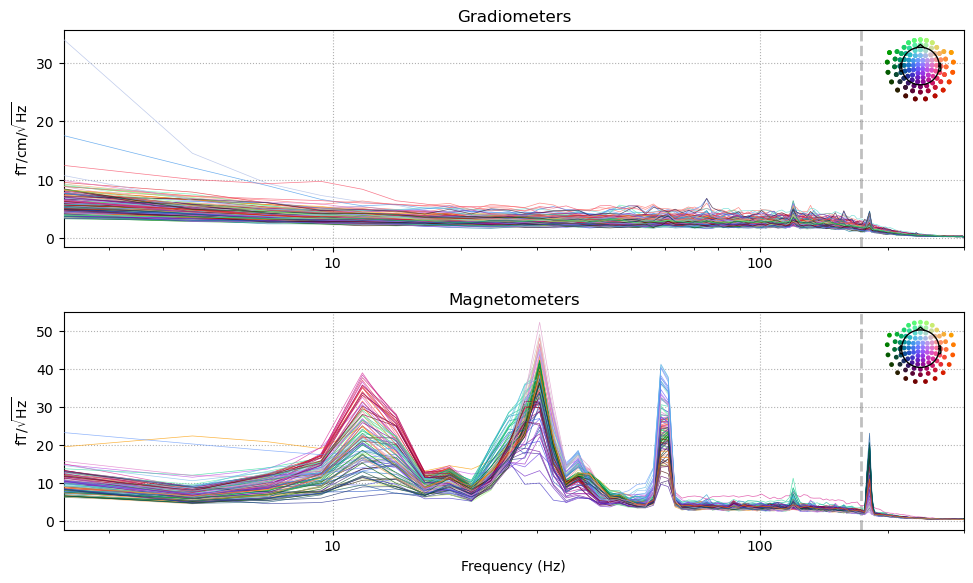

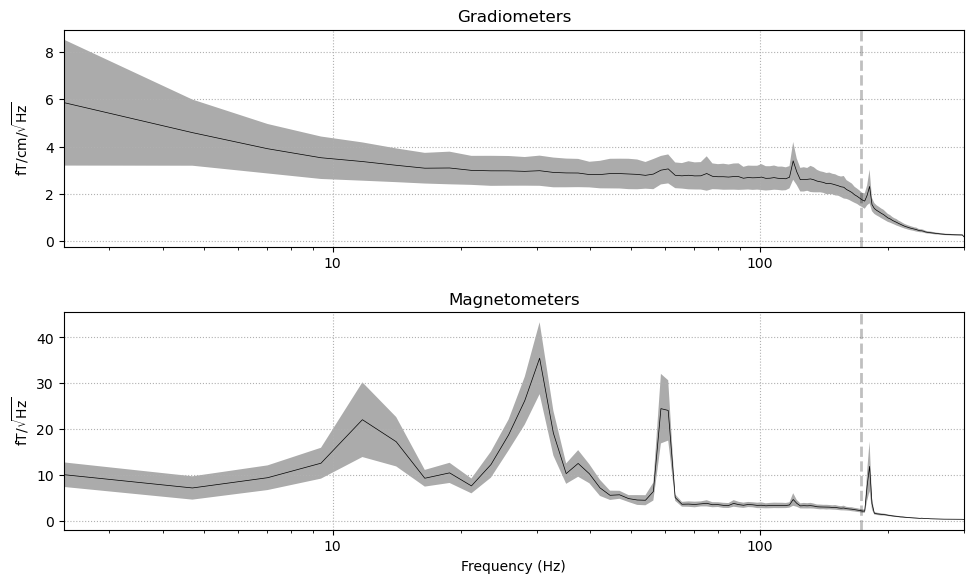

In [8]:
for average in (False, True):
    empty_room_raw.plot_psd(average=average, dB=False, xscale='log')

Not setting metadata
29 matching events found
No baseline correction applied


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  29 out of  29 | elapsed:    0.2s finished


Adding projection: planar-Raw-0.000-30.001-PCA-01
Adding projection: planar-Raw-0.000-30.001-PCA-02
Adding projection: planar-Raw-0.000-30.001-PCA-03
Adding projection: axial-Raw-0.000-30.001-PCA-01
Adding projection: axial-Raw-0.000-30.001-PCA-02
Adding projection: axial-Raw-0.000-30.001-PCA-03


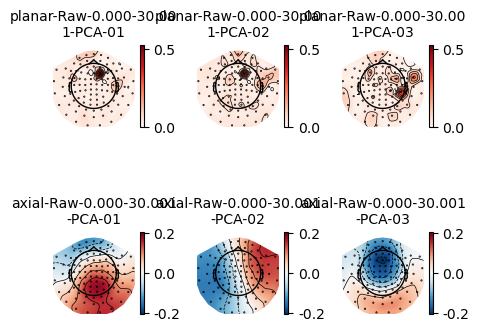

In [10]:
empty_room_projs = mne.compute_proj_raw(empty_room_raw, n_grad=3, n_mag=3)
mne.viz.plot_projs_topomap(empty_room_projs, colorbar=True, vlim='joint',
                           info=empty_room_raw.info);

visualize the projector affect the signal

3 projection items deactivated
Using matplotlib as 2D backend.


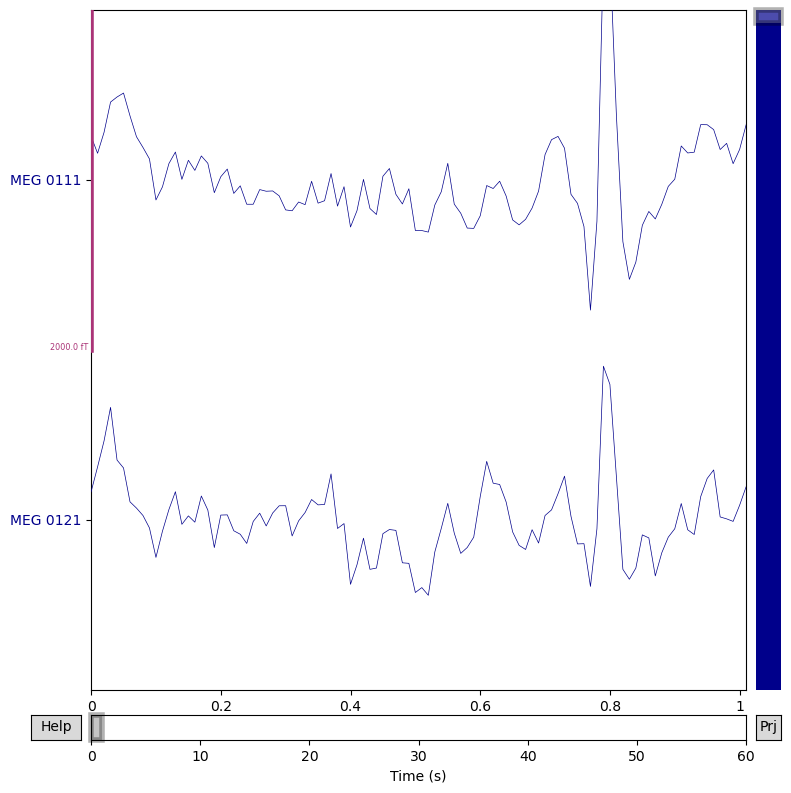

3 projection items deactivated


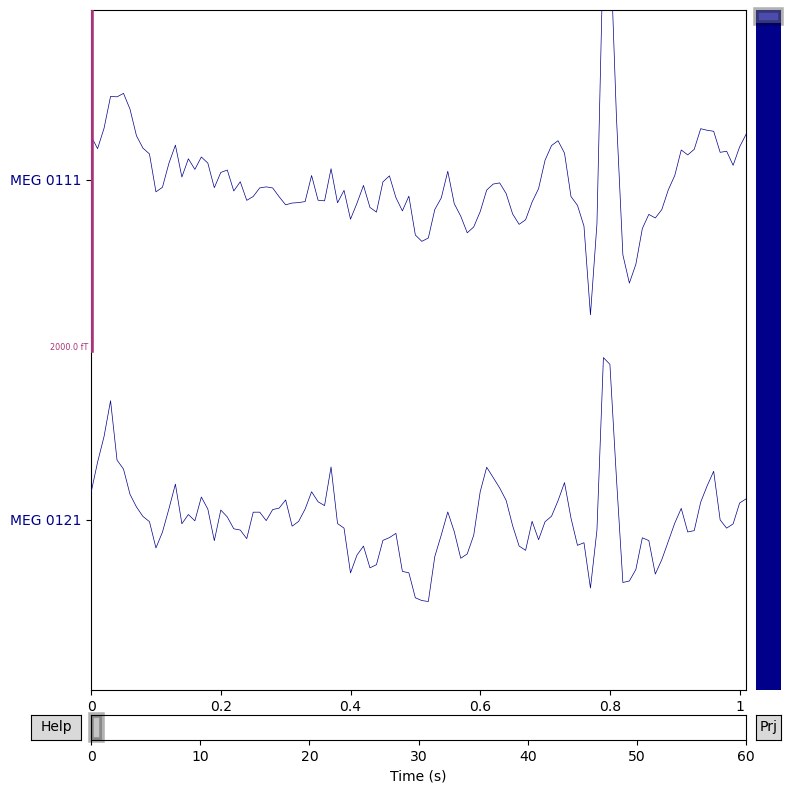

In [13]:
mags = mne.pick_types(raw.info, meg='mag')
for title, projs in [('system', system_projs),
                     ('subject-specific', empty_room_projs[3:])]:
    raw.add_proj(projs, remove_existing=True)
    with mne.viz.use_browser_backend('matplotlib'):
        fig = raw.plot(proj=True, order=mags, duration=1, n_channels=2)
    fig.subplots_adjust(top=0.9)  # make room for title
    fig.suptitle('{} projectors'.format(title), size='xx-large', weight='bold')

# EcG artifact repair with projector

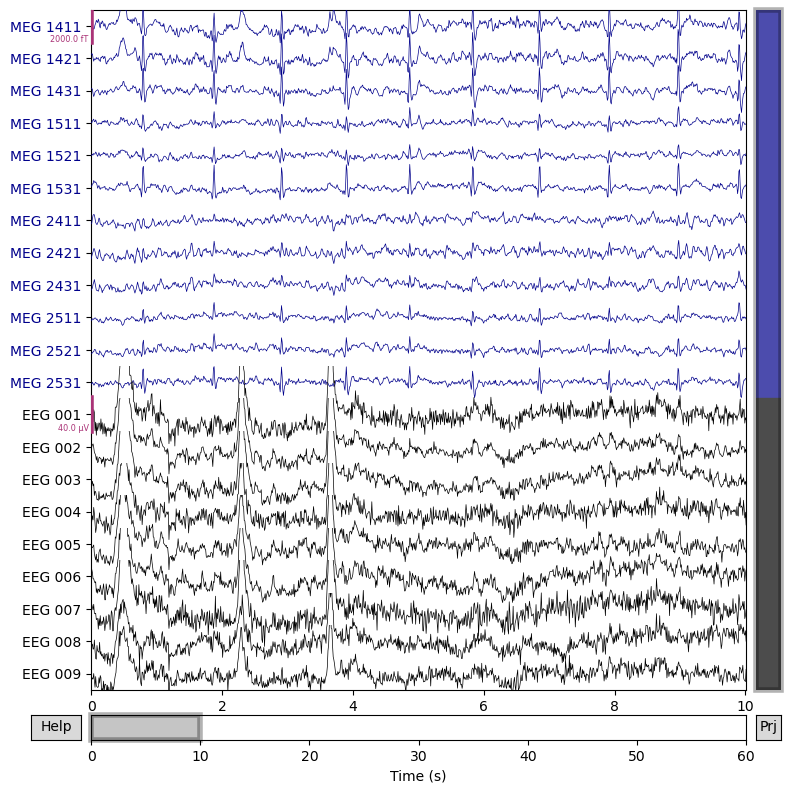

In [15]:
# pick some channels that clearly show heartbeats and blinks
regexp = r'(MEG [12][45][123]1|EEG 00.)'
artifact_picks = mne.pick_channels_regexp(raw.ch_names, regexp=regexp)
raw.plot(order=artifact_picks, n_channels=len(artifact_picks));

Reconstructing ECG signal from Magnetometers
Setting up band-pass filter from 8 - 16 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 8.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 7.75 Hz)
- Upper passband edge: 16.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 16.25 Hz)
- Filter length: 1000 samples (10.000 sec)

Number of ECG events detected : 59 (average pulse 59 / min.)
Not setting metadata
59 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 3)
Using data from preloaded Raw for 59 events and 101 original time points ...
0 bad epochs dropped
Created an SSP operator (subspace dimension = 3)
3 projection items activated
SSP projectors applied...
Removing projector <Projection | axial-Raw-0.000-30.001-PCA-01, active : True, 

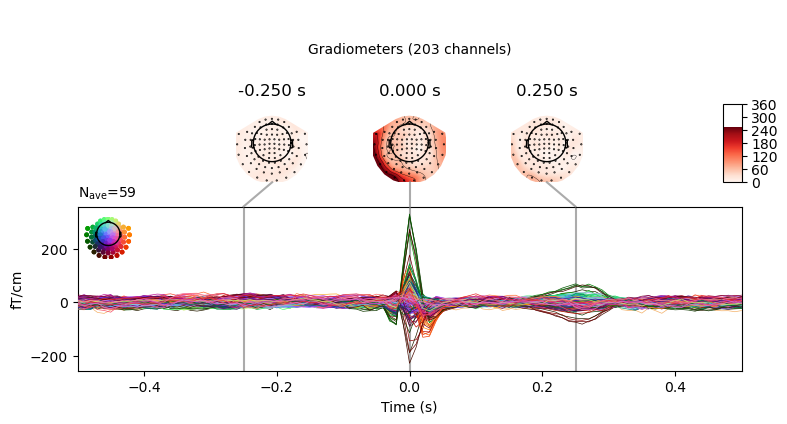

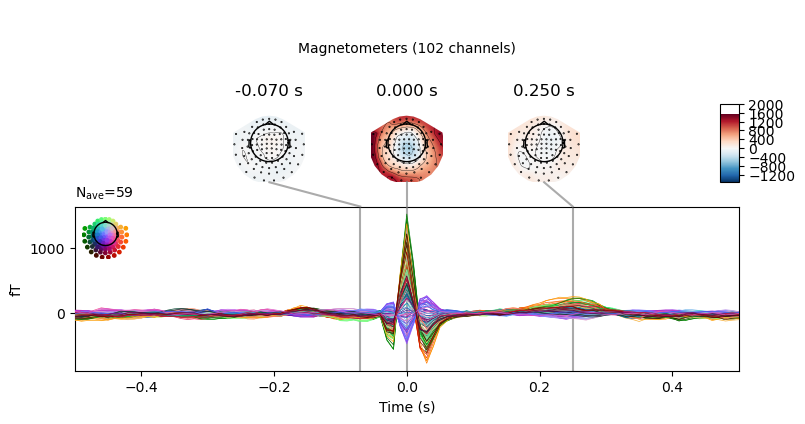

Removing projector <Projection | axial-Raw-0.000-30.001-PCA-01, active : True, n_channels : 102, exp. var : 80.59%>
Removing projector <Projection | axial-Raw-0.000-30.001-PCA-02, active : True, n_channels : 102, exp. var : 14.59%>
Removing projector <Projection | axial-Raw-0.000-30.001-PCA-03, active : True, n_channels : 102, exp. var : 3.87%>


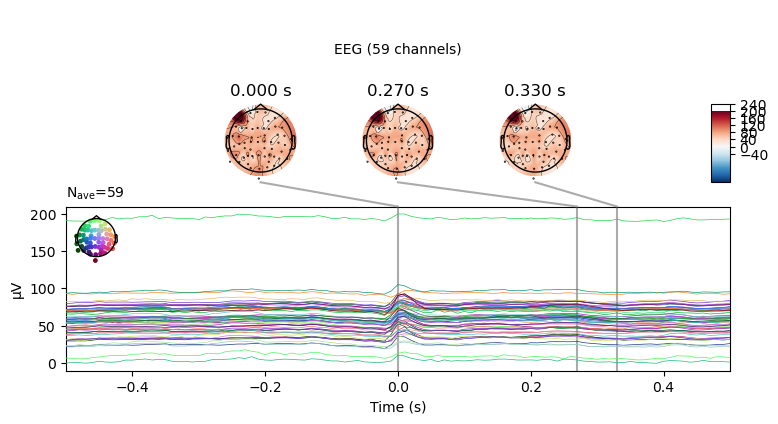

In [16]:
ecg_evoked = create_ecg_epochs(raw).average()
ecg_evoked.plot_joint();

Applying baseline correction (mode: mean)
Created an SSP operator (subspace dimension = 3)
3 projection items activated
SSP projectors applied...
Removing projector <Projection | axial-Raw-0.000-30.001-PCA-01, active : True, n_channels : 102, exp. var : 80.59%>
Removing projector <Projection | axial-Raw-0.000-30.001-PCA-02, active : True, n_channels : 102, exp. var : 14.59%>
Removing projector <Projection | axial-Raw-0.000-30.001-PCA-03, active : True, n_channels : 102, exp. var : 3.87%>


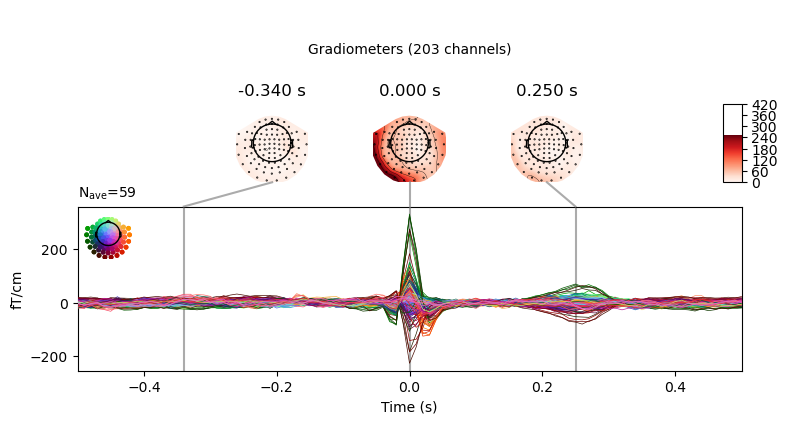

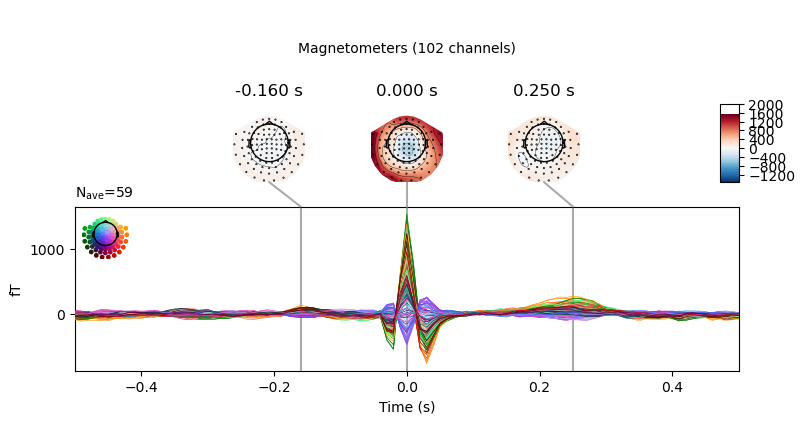

Removing projector <Projection | axial-Raw-0.000-30.001-PCA-01, active : True, n_channels : 102, exp. var : 80.59%>
Removing projector <Projection | axial-Raw-0.000-30.001-PCA-02, active : True, n_channels : 102, exp. var : 14.59%>
Removing projector <Projection | axial-Raw-0.000-30.001-PCA-03, active : True, n_channels : 102, exp. var : 3.87%>


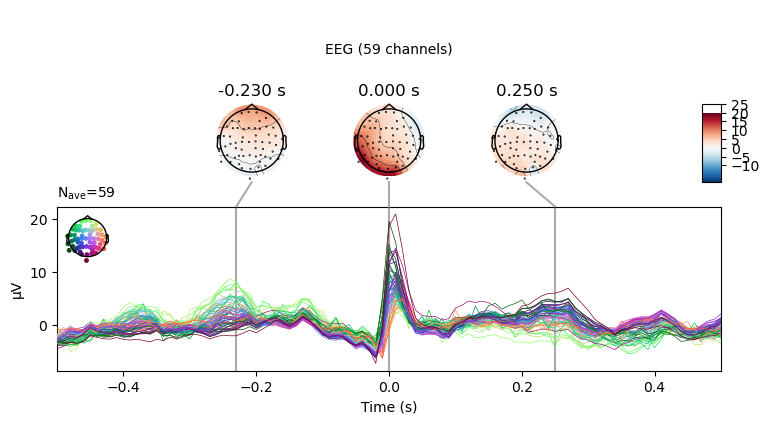

In [17]:
# baseline correct and plot
ecg_evoked.apply_baseline((None, None))
ecg_evoked.plot_joint();

In [18]:
projs, events = compute_proj_ecg(raw, n_grad=1, n_mag=1, n_eeg=1, reject=None)

Including 3 SSP projectors from raw file
Running ECG SSP computation
Reconstructing ECG signal from Magnetometers
Setting up band-pass filter from 5 - 35 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 5.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 4.75 Hz)
- Upper passband edge: 35.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 35.25 Hz)
- Filter length: 1000 samples (10.000 sec)

Number of ECG events detected : 58 (average pulse 58 / min.)
Computing projector
Filtering a subset of channels. The highpass and lowpass values in the measurement info will not be updated.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 35 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filt

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Not setting metadata
58 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 3)
3 projection items activated
Using data from preloaded Raw for 58 events and 61 original time points ...


[Parallel(n_jobs=1)]: Done 365 out of 365 | elapsed:    0.4s finished


0 bad epochs dropped
Adding projection: planar--0.200-0.400-PCA-01
Adding projection: axial--0.200-0.400-PCA-01
Adding projection: eeg--0.200-0.400-PCA-01
Done.


In [19]:
ecg_projs = projs[3:]
print(ecg_projs)

[<Projection | ECG-planar--0.200-0.400-PCA-01, active : False, n_channels : 203, exp. var : 74.55%>, <Projection | ECG-axial--0.200-0.400-PCA-01, active : False, n_channels : 102, exp. var : 94.96%>, <Projection | ECG-eeg--0.200-0.400-PCA-01, active : False, n_channels : 59, exp. var : 77.45%>]


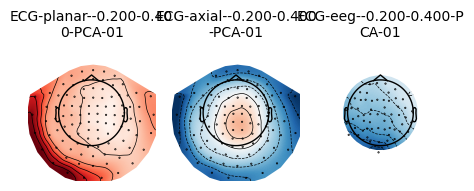

In [20]:
mne.viz.plot_projs_topomap(ecg_projs, info=raw.info);

The left shows the data traces before (black) and after (green) projection. We can see that the ECG artifact is well suppressed by one projector per channel type.
The center shows the topomaps associated with the projectors, in this case just a single topography for our one projector per channel type.
The right again shows the data traces (black), but this time with those traces also projected onto the first projector for each channel type (red) plus one surrogate ground truth for an ECG channel (MEG 0111).

Removing projector <Projection | axial-Raw-0.000-30.001-PCA-01, active : False, n_channels : 102, exp. var : 80.59%>
Removing projector <Projection | axial-Raw-0.000-30.001-PCA-02, active : False, n_channels : 102, exp. var : 14.59%>
Removing projector <Projection | axial-Raw-0.000-30.001-PCA-03, active : False, n_channels : 102, exp. var : 3.87%>
1 projection items deactivated
1 projection items deactivated
Removing projector <Projection | axial-Raw-0.000-30.001-PCA-01, active : False, n_channels : 102, exp. var : 80.59%>
Removing projector <Projection | axial-Raw-0.000-30.001-PCA-02, active : False, n_channels : 102, exp. var : 14.59%>
Removing projector <Projection | axial-Raw-0.000-30.001-PCA-03, active : False, n_channels : 102, exp. var : 3.87%>
1 projection items deactivated


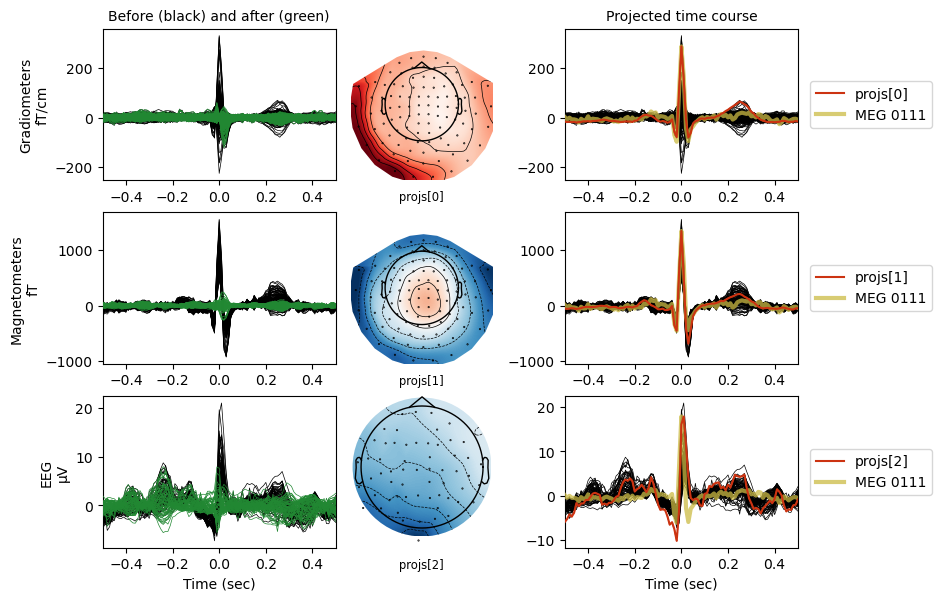

Text(0.5, 0.98, 'ECG projectors')

In [21]:
# ideally here we would just do `picks_trace='ecg'`, but this dataset did not
# have a dedicated ECG channel recorded, so we just pick a channel that was
# very sensitive to the artifact
fig = mne.viz.plot_projs_joint(ecg_projs, ecg_evoked, picks_trace='MEG 0111')
fig.suptitle('ECG projectors')

6 projection items deactivated


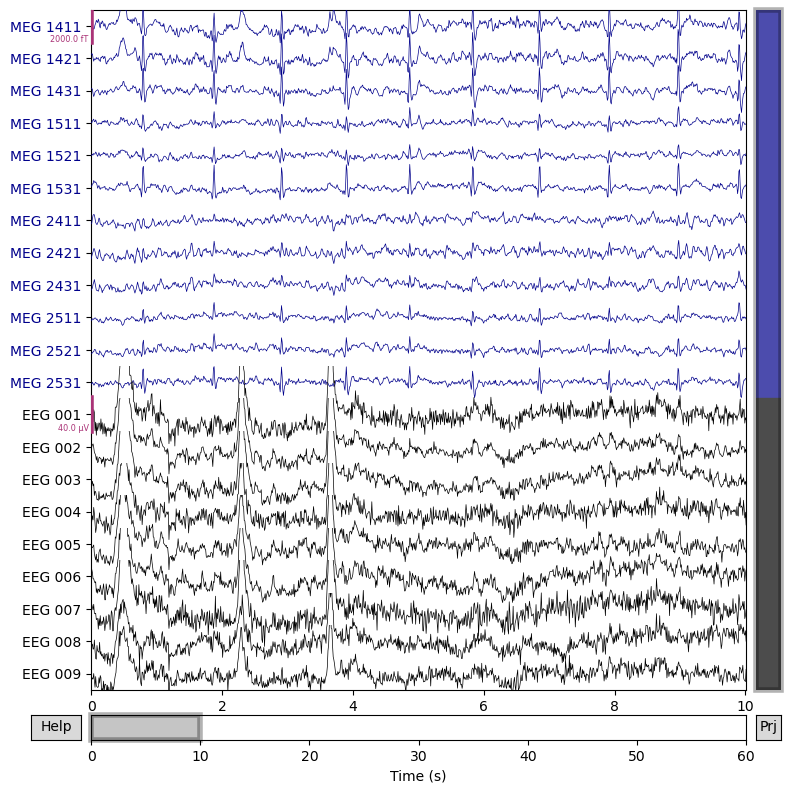

3 projection items deactivated


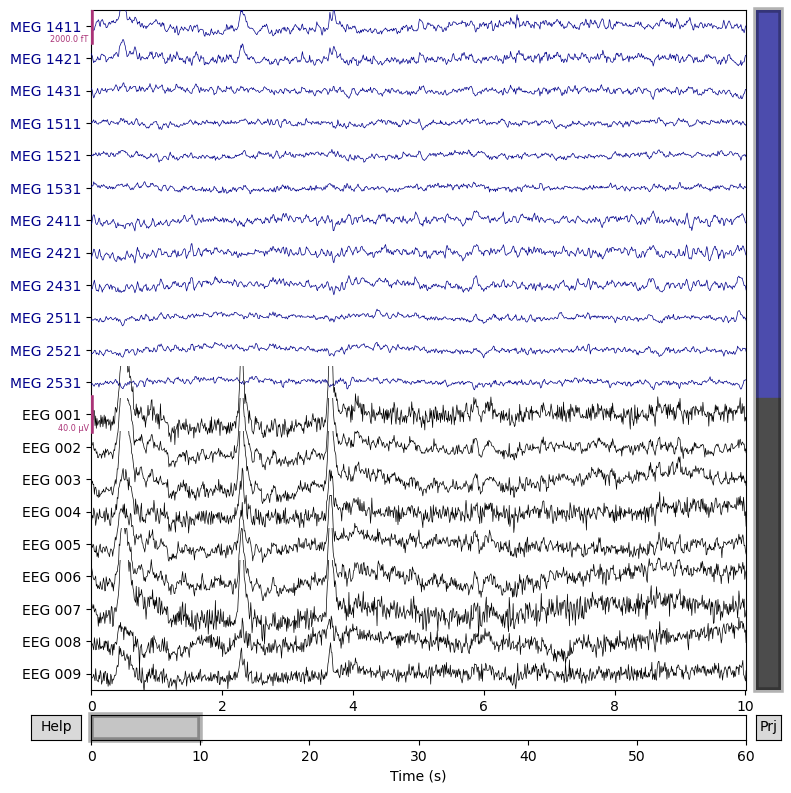

In [23]:
raw.del_proj()
for title, proj in [('Without', empty_room_projs), ('With', ecg_projs)]:
    raw.add_proj(proj, remove_existing=False)
    with mne.viz.use_browser_backend('matplotlib'):
        fig = raw.plot(order=artifact_picks, n_channels=len(artifact_picks))
    fig.subplots_adjust(top=0.9)  # make room for title
    fig.suptitle('{} ECG projectors'.format(title), size='xx-large',
                 weight='bold');

# repairing EOG artiffact with SSP

Using EOG channel: EOG 061
EOG channel index for this subject is: [375]
Filtering the data to remove DC offset to help distinguish blinks from saccades
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 1000 samples (10.000 sec)

Now detecting blinks and generating corresponding events
Found 10 significant peaks
Number of EOG events detected: 10
Not setting metadata
10 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 9)
Using data from preloaded Raw for 10 events and 101 original time points ...
0 bad epochs dropped
Applying baseline c

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


SSP projectors applied...
Removing projector <Projection | axial-Raw-0.000-30.001-PCA-01, active : True, n_channels : 102, exp. var : 80.59%>
Removing projector <Projection | axial-Raw-0.000-30.001-PCA-02, active : True, n_channels : 102, exp. var : 14.59%>
Removing projector <Projection | axial-Raw-0.000-30.001-PCA-03, active : True, n_channels : 102, exp. var : 3.87%>
Removing projector <Projection | ECG-axial--0.200-0.400-PCA-01, active : True, n_channels : 102, exp. var : 94.96%>
Removing projector <Projection | ECG-eeg--0.200-0.400-PCA-01, active : True, n_channels : 59, exp. var : 77.45%>


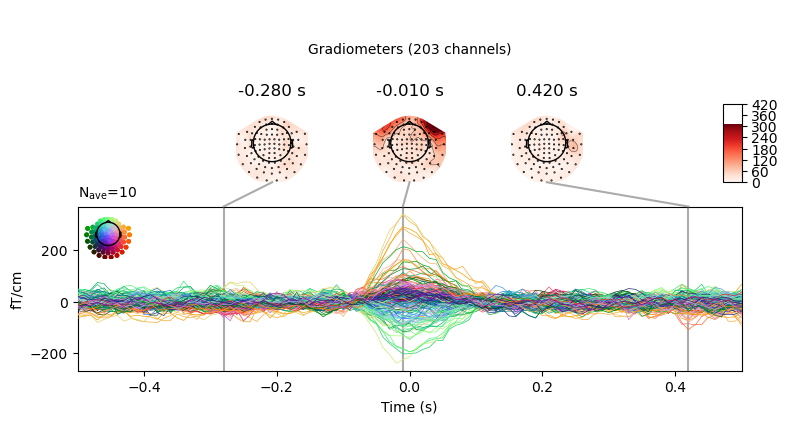

Removing projector <Projection | planar-Raw-0.000-30.001-PCA-01, active : True, n_channels : 203, exp. var : 5.08%>
Removing projector <Projection | planar-Raw-0.000-30.001-PCA-02, active : True, n_channels : 203, exp. var : 4.38%>
Removing projector <Projection | planar-Raw-0.000-30.001-PCA-03, active : True, n_channels : 203, exp. var : 2.99%>
Removing projector <Projection | ECG-planar--0.200-0.400-PCA-01, active : True, n_channels : 203, exp. var : 74.55%>
Removing projector <Projection | ECG-eeg--0.200-0.400-PCA-01, active : True, n_channels : 59, exp. var : 77.45%>


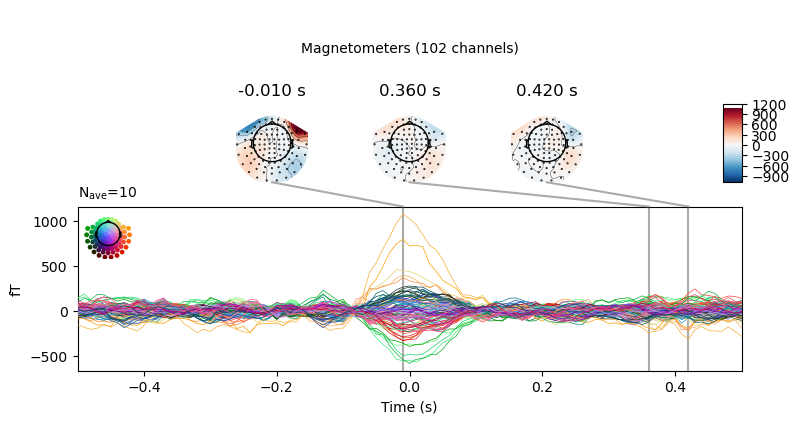

Removing projector <Projection | planar-Raw-0.000-30.001-PCA-01, active : True, n_channels : 203, exp. var : 5.08%>
Removing projector <Projection | planar-Raw-0.000-30.001-PCA-02, active : True, n_channels : 203, exp. var : 4.38%>
Removing projector <Projection | planar-Raw-0.000-30.001-PCA-03, active : True, n_channels : 203, exp. var : 2.99%>
Removing projector <Projection | axial-Raw-0.000-30.001-PCA-01, active : True, n_channels : 102, exp. var : 80.59%>
Removing projector <Projection | axial-Raw-0.000-30.001-PCA-02, active : True, n_channels : 102, exp. var : 14.59%>
Removing projector <Projection | axial-Raw-0.000-30.001-PCA-03, active : True, n_channels : 102, exp. var : 3.87%>
Removing projector <Projection | ECG-planar--0.200-0.400-PCA-01, active : True, n_channels : 203, exp. var : 74.55%>
Removing projector <Projection | ECG-axial--0.200-0.400-PCA-01, active : True, n_channels : 102, exp. var : 94.96%>


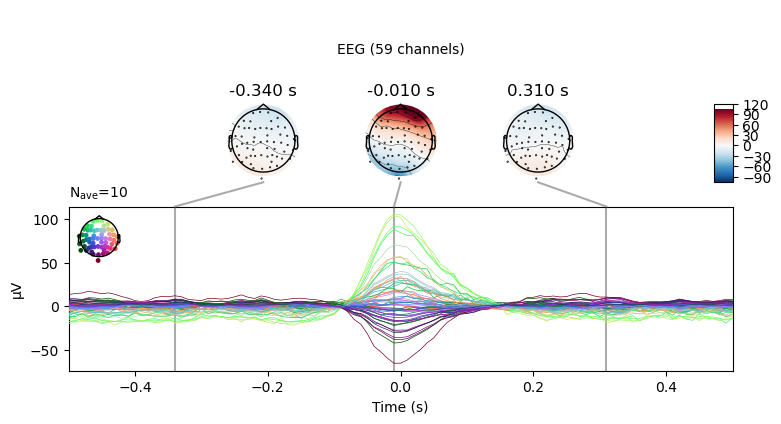

In [25]:
eog_evoked = create_eog_epochs(raw).average(picks='all')
eog_evoked.apply_baseline((None, None))
eog_evoked.plot_joint();

In [26]:
eog_projs, _ = compute_proj_eog(raw, n_grad=1, n_mag=1, n_eeg=1, reject=None,
                                no_proj=True)

Running EOG SSP computation
Using EOG channel: EOG 061
EOG channel index for this subject is: [375]
Filtering the data to remove DC offset to help distinguish blinks from saccades
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 1000 samples (10.000 sec)

Now detecting blinks and generating corresponding events
Found 10 significant peaks
Number of EOG events detected: 10
Computing projector
Filtering a subset of channels. The highpass and lowpass values in the measurement info will not be updated.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 35 Hz


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Not setting metadata
10 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 9)
9 projection items activated
Using data from preloaded Raw for 10 events and 41 original time points ...
0 bad epochs dropped
Adding projection: planar--0.200-0.200-PCA-01
Adding projection: axial--0.200-0.200-PCA-01
Adding projection: eeg--0.200-0.200-PCA-01
Done.


[Parallel(n_jobs=1)]: Done 365 out of 365 | elapsed:    0.4s finished


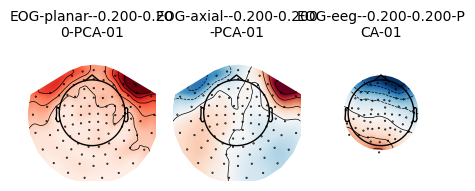

In [27]:
mne.viz.plot_projs_topomap(eog_projs, info=raw.info);

Removing projector <Projection | axial-Raw-0.000-30.001-PCA-01, active : False, n_channels : 102, exp. var : 80.59%>
Removing projector <Projection | axial-Raw-0.000-30.001-PCA-02, active : False, n_channels : 102, exp. var : 14.59%>
Removing projector <Projection | axial-Raw-0.000-30.001-PCA-03, active : False, n_channels : 102, exp. var : 3.87%>
Removing projector <Projection | ECG-axial--0.200-0.400-PCA-01, active : False, n_channels : 102, exp. var : 94.96%>
Removing projector <Projection | ECG-eeg--0.200-0.400-PCA-01, active : False, n_channels : 59, exp. var : 77.45%>
1 projection items deactivated
Removing projector <Projection | planar-Raw-0.000-30.001-PCA-01, active : False, n_channels : 203, exp. var : 5.08%>
Removing projector <Projection | planar-Raw-0.000-30.001-PCA-02, active : False, n_channels : 203, exp. var : 4.38%>
Removing projector <Projection | planar-Raw-0.000-30.001-PCA-03, active : False, n_channels : 203, exp. var : 2.99%>
Removing projector <Projection | ECG-

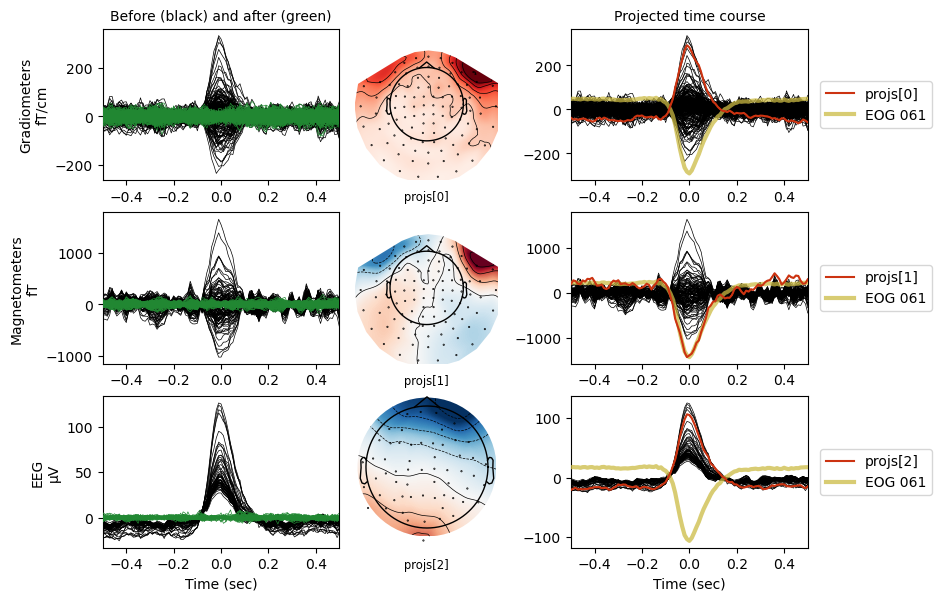

Text(0.5, 0.98, 'EOG projectors')

In [28]:
fig = mne.viz.plot_projs_joint(eog_projs, eog_evoked, 'eog');
fig.suptitle('EOG projectors')

86 events found
Event IDs: [ 1  2  3  4  5 32]
Not setting metadata
20 matching events found
Setting baseline interval to [-0.2, 0.0] sec
Applying baseline correction (mode: mean)
Entering delayed SSP mode.
Created an SSP operator (subspace dimension = 9)
    Rejecting  epoch based on EEG : ['EEG 003', 'EEG 007']


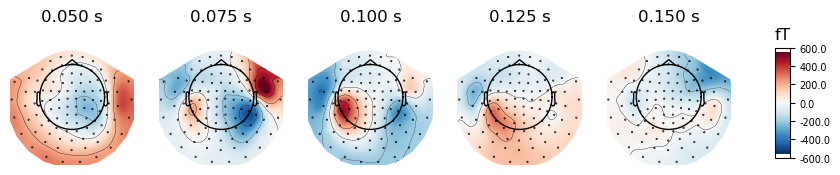

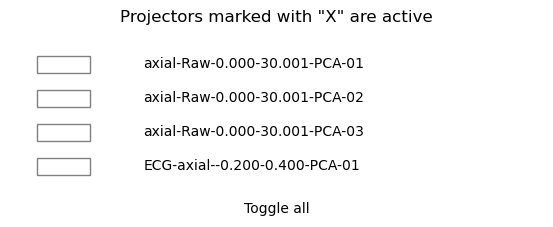

In [30]:
events = mne.find_events(raw, stim_channel='STI 014')
event_id = {'auditory/left': 1}

# NOTE: appropriate rejection criteria are highly data-dependent
reject = dict(mag=4000e-15,     # 4000 fT
              grad=4000e-13,    # 4000 fT/cm
              eeg=150e-6,       # 150 µV
              eog=250e-6)       # 250 µV

# time range where we expect to see the auditory N100: 50-150 ms post-stimulus
times = np.linspace(0.05, 0.15, 5)

epochs = mne.Epochs(raw, events, event_id, proj='delayed', reject=reject)
fig = epochs.average().plot_topomap(times, proj='interactive')

    Rejecting  epoch based on EEG : ['EEG 003', 'EEG 007']
Removing projector <Projection | planar-Raw-0.000-30.001-PCA-01, active : False, n_channels : 203, exp. var : 5.08%>
Removing projector <Projection | planar-Raw-0.000-30.001-PCA-02, active : False, n_channels : 203, exp. var : 4.38%>
Removing projector <Projection | planar-Raw-0.000-30.001-PCA-03, active : False, n_channels : 203, exp. var : 2.99%>
Removing projector <Projection | axial-Raw-0.000-30.001-PCA-01, active : False, n_channels : 102, exp. var : 80.59%>
Removing projector <Projection | axial-Raw-0.000-30.001-PCA-02, active : False, n_channels : 102, exp. var : 14.59%>
Removing projector <Projection | axial-Raw-0.000-30.001-PCA-03, active : False, n_channels : 102, exp. var : 3.87%>
Removing projector <Projection | ECG-planar--0.200-0.400-PCA-01, active : False, n_channels : 203, exp. var : 74.55%>
Removing projector <Projection | ECG-axial--0.200-0.400-PCA-01, active : False, n_channels : 102, exp. var : 94.96%>
3 pro

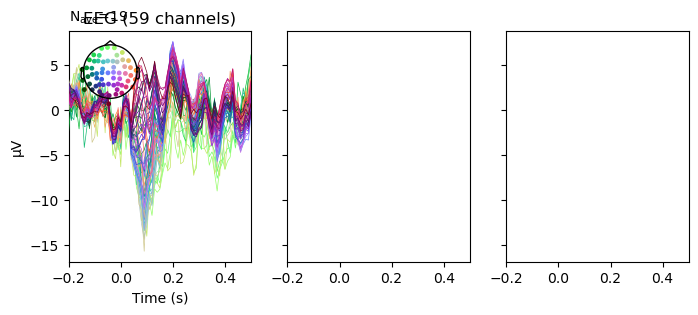

In [ ]:
evoked_eeg = epochs.average().pick('eeg')
evoked_eeg.del_proj().add_proj(ecg_projs).add_proj(eog_projs)
fig, axes = plt.subplots(1, 3, figsize=(8, 3), sharex=True, sharey=True)
for pi, proj in enumerate((False, True, 'reconstruct')):
    ax = axes[pi]
    evoked_eeg.plot(proj=proj, axes=ax, spatial_colors=True)
    parts = ax.get_title().split('(')
    ylabel = (f'{parts[0]} ({ax.get_ylabel()})\n{parts[1].replace(")", "")}'
              if pi == 0 else '')
    ax.set(ylabel=ylabel, title=f'proj={proj}')
    ax.yaxis.set_tick_params(labelbottom=True)
    for text in list(ax.texts):
        text.remove()
mne.viz.tight_layout()